---

In [10]:
from traffic_accident_impact.utils import *
from traffic_accident_impact.config import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plan

- normalize columns name

- drop unnecessary columns

- filling `Precipitation(in)`  and `Wind_Chill(F)` with the average of non-missing values from the same month.

- outliers removal

- create `Duration` column with `Start_Time` and `End_Time`, and getting start day, month, year

- vectorize accident description columns

- create pipeline for training

## Preprocessing

We preprocessed the dataset as described in [EDA-1](./EDA-1.ipynb) on an AWS EMR cluster using PySpark for steps 1 to 5 (Code [here](../traffic_accident_impact/processing_spark.py) ).   
For step 6, since using OpenAI's `text-embedding-ada-002` model was not feasible due to the data size, we opted for a traditional vectorization approach using `Doc2Vec` (Code [here](../traffic_accident_impact/text_preprocessing.py)).   


After completing the initial preprocessing and text processing phases, an additional feature engineering phase was necessary to refine the dataset for modeling.  
This step aimed to enhance the predictive power of features by transforming, grouping, and reducing them, ensuring the dataset was optimized (Code [here](../traffic_accident_impact/feature_engineering.py)).

In [2]:
df = pd.read_parquet(PROCESSED_DATA_DIR / "final/final_processed_data.parquet")

In [3]:
df.sample(3)

,severity,start_lat,distance(mi),timezone,temperature(f),humidity(%),pressure(in),wind_speed(mph),precipitation(in),accident_duration(min),...,sin_start_hour,cos_start_hour,sin_start_day,cos_start_day,sin_start_month,cos_start_month,sin_wind_angle,cos_wind_angle,state_group,weather_group
1779215,2,32.813732,0.01,us/central,73.0,17.0,30.09,3.5,0.074287,60.583333,...,-0.258819,-0.965926,0.974928,-0.222521,5.000000e-01,0.866025,-9.238795e-01,0.382683,urban,cloudy
2118164,2,41.463589,0.00,us/eastern,28.0,46.0,29.94,5.8,0.039320,29.616667,...,-0.866025,-0.500000,0.781831,0.623490,-2.449294e-16,1.000000,-3.826834e-01,-0.923880,urban,clear
2101138,3,39.268162,0.00,us/mountain,17.6,68.0,30.04,9.2,0.033197,44.416667,...,-0.965926,-0.258819,-0.433884,-0.900969,5.000000e-01,0.866025,1.224647e-16,-1.000000,rural,clear


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3976010 entries, 0 to 3976009
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   severity                object 
 1   start_lat               float64
 2   distance(mi)            float64
 3   timezone                object 
 4   temperature(f)          float64
 5   humidity(%)             float64
 6   pressure(in)            float64
 7   wind_speed(mph)         float64
 8   precipitation(in)       float64
 9   accident_duration(min)  float64
 10  start_year              object 
 11  description_pca1        float32
 12  description_pca2        float32
 13  description_pca3        float32
 14  sin_start_lng           float64
 15  cos_start_lng           float64
 16  sin_start_hour          float64
 17  cos_start_hour          float64
 18  sin_start_day           float64
 19  cos_start_day           float64
 20  sin_start_month         float64
 21  cos_start_month         float64

In [5]:
df.isna().sum().sum()

0

In [6]:
numerical_cols_name = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
categorical_cols_name = df.select_dtypes(include=['object']).columns

In [7]:
for col in categorical_cols_name:
    print(f"{col} ------> {df[col].nunique()}")

severity ------> 4
timezone ------> 4
start_year ------> 8
state_group ------> 2
weather_group ------> 4


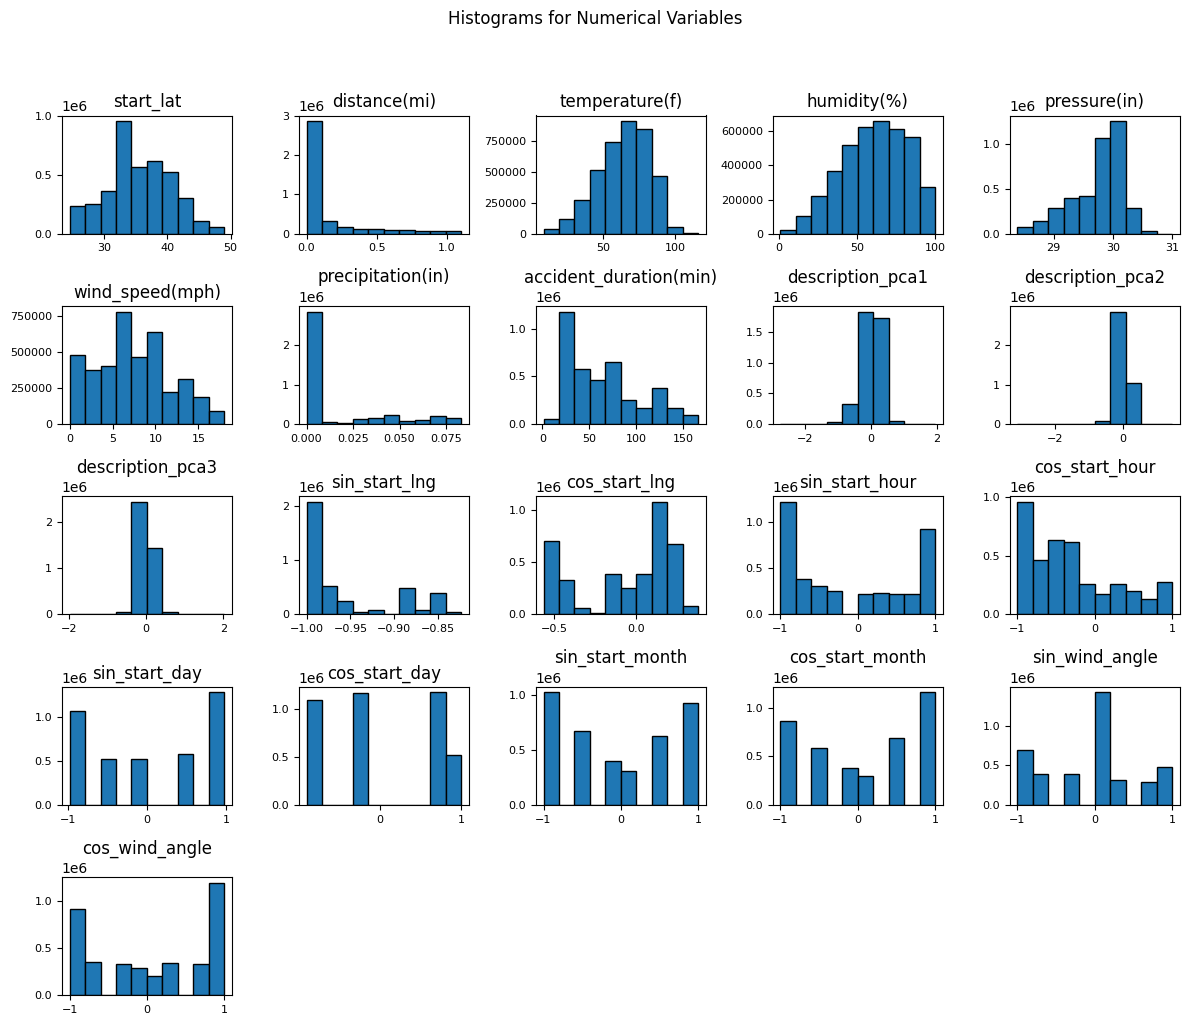

In [8]:
df[numerical_cols_name].hist(bins=10, figsize=(12, 10), grid=False, xlabelsize=8, ylabelsize=8,  edgecolor='black')
plt.suptitle('Histograms for Numerical Variables', y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "histograms" / "final_features_histograms.png", dpi=300)
plt.show()
plt.close()

In [11]:
correlation_matrix = df[numerical_cols_name].corr()

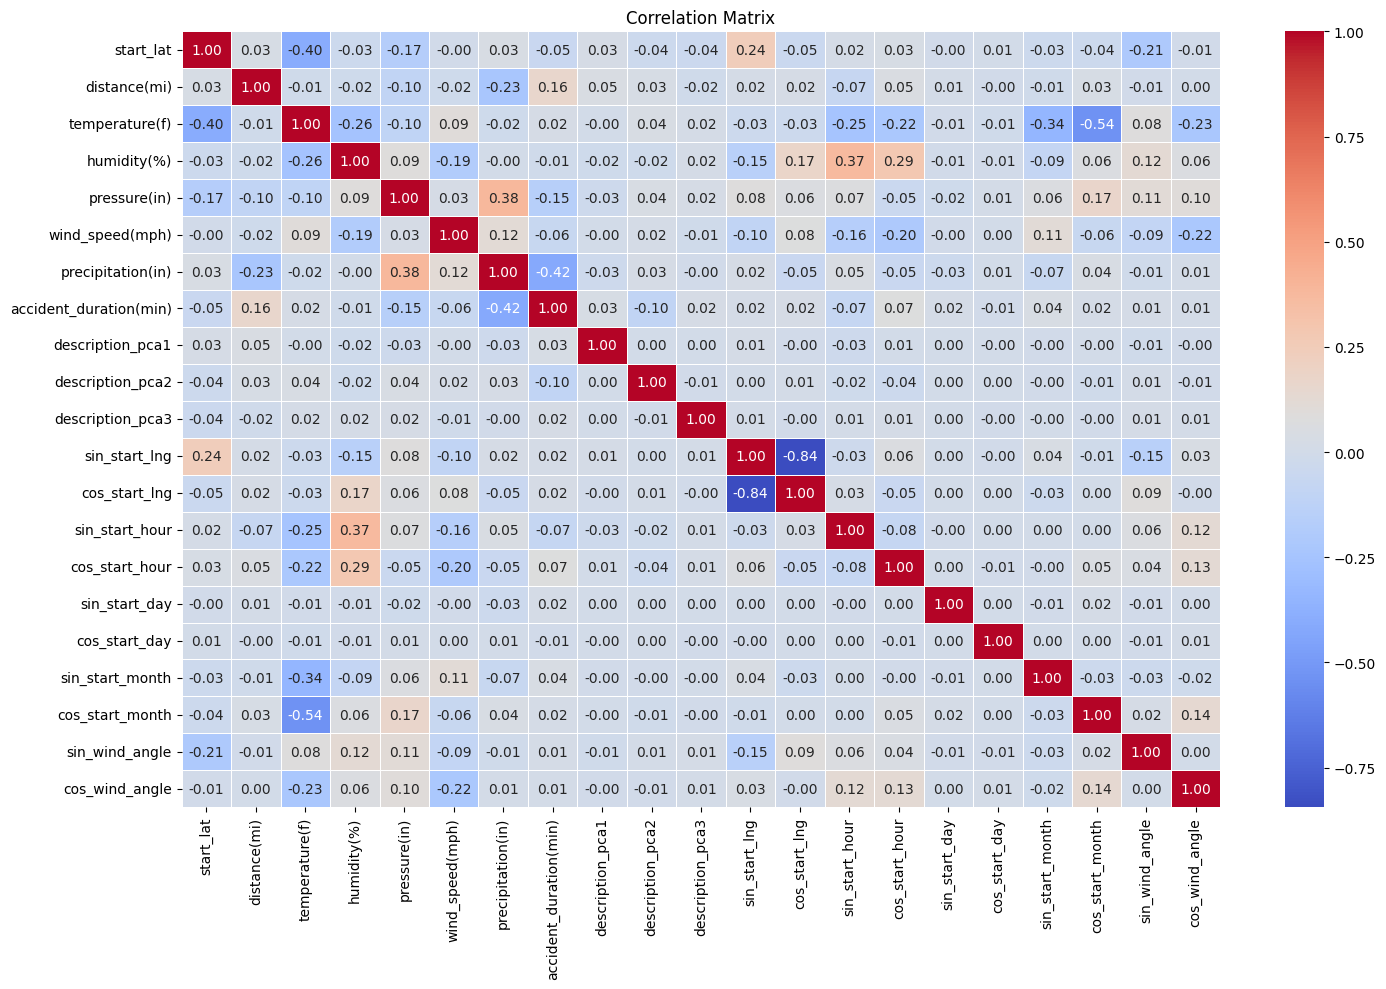

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "final_correlation_matrix.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

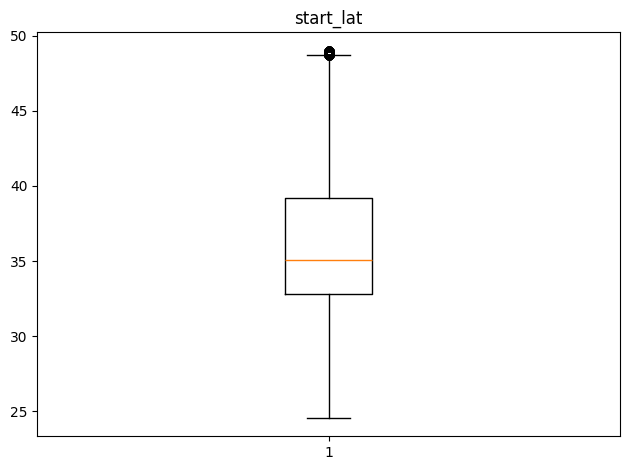

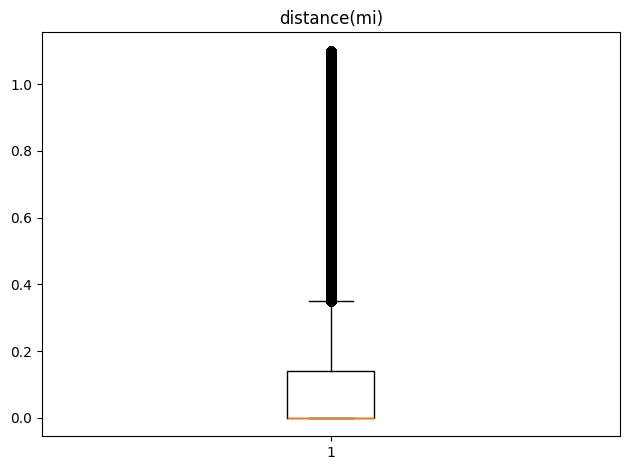

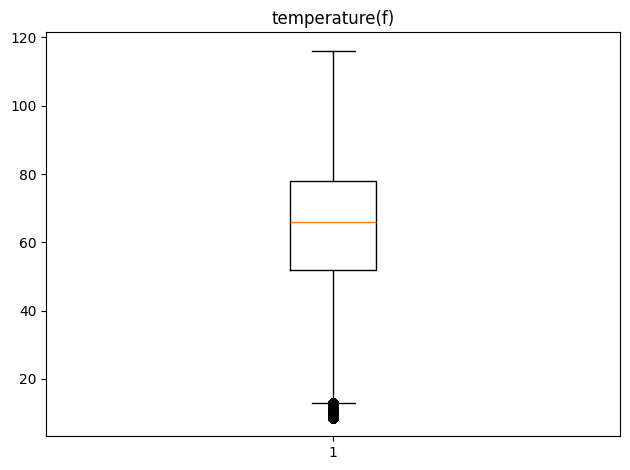

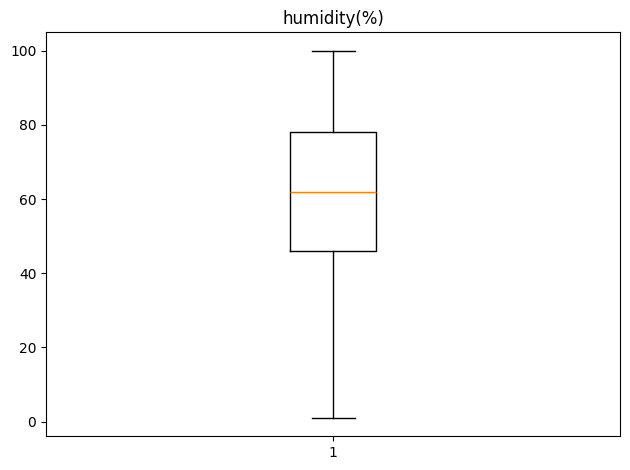

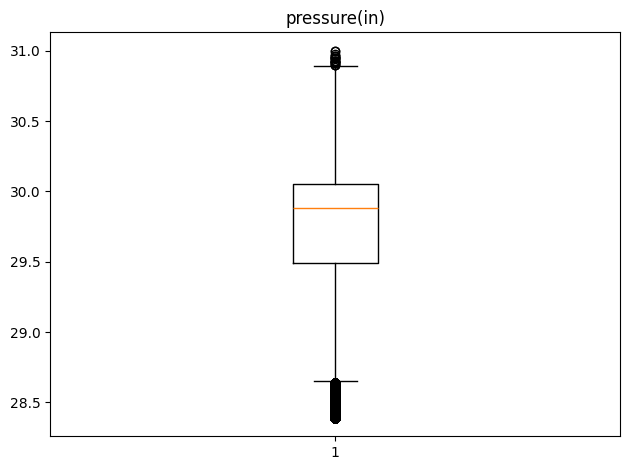

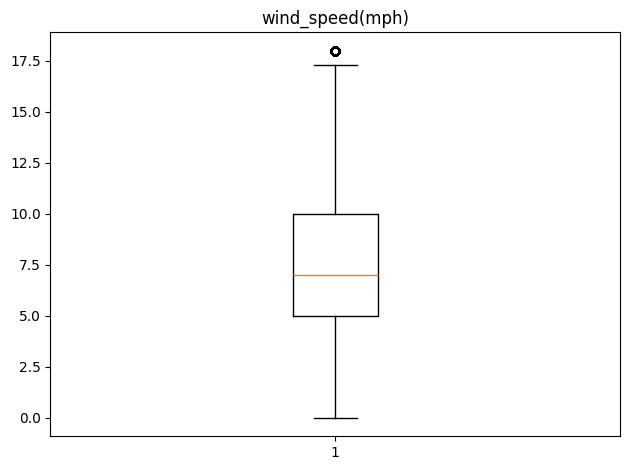

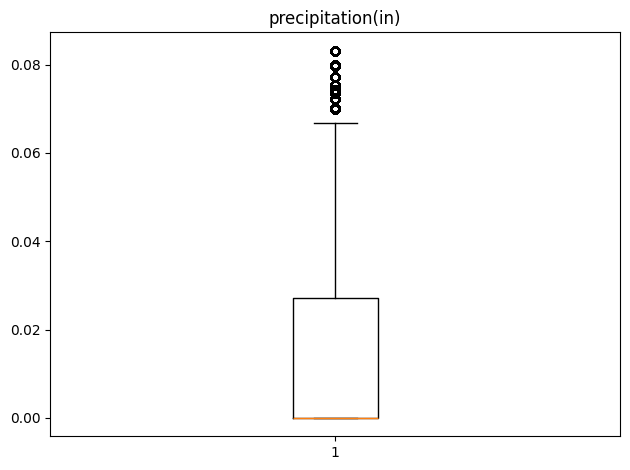

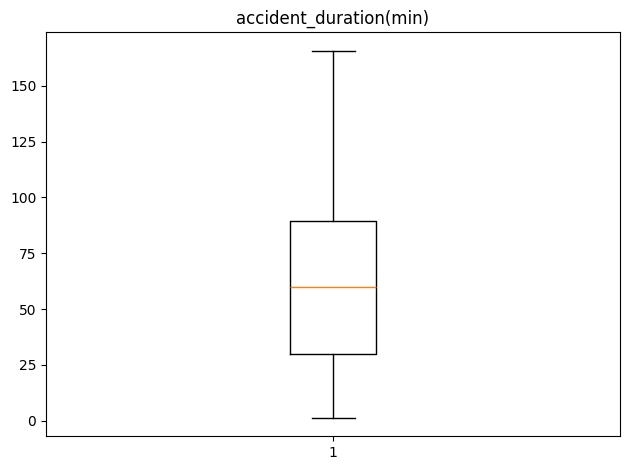

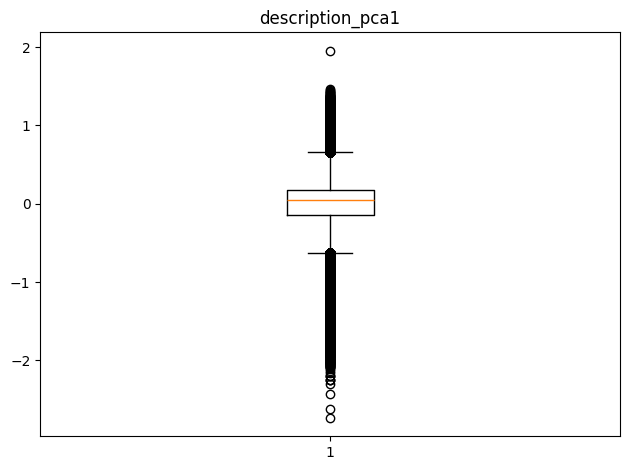

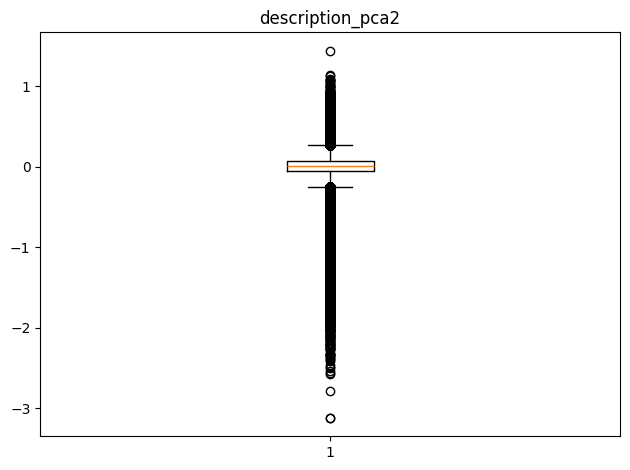

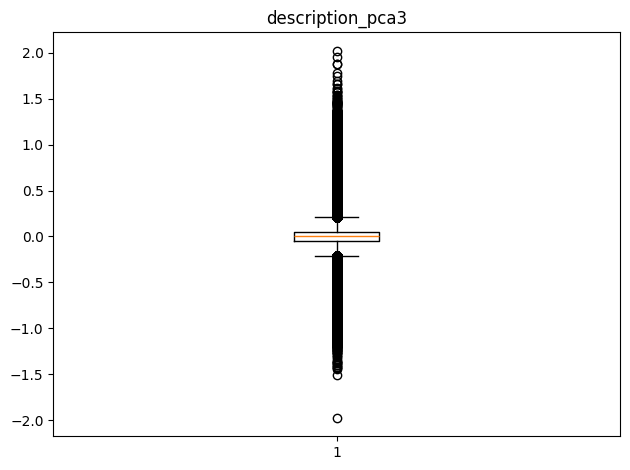

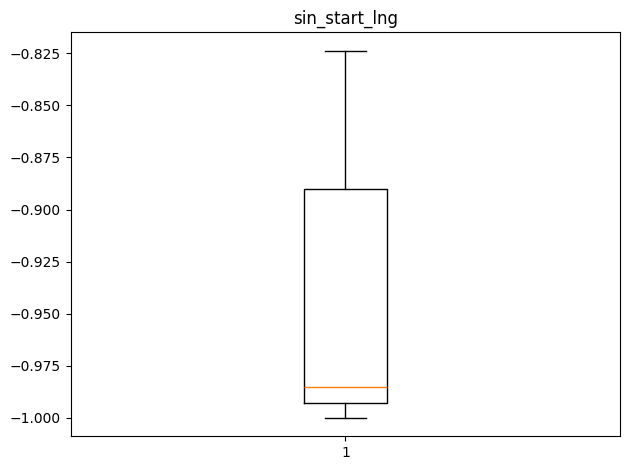

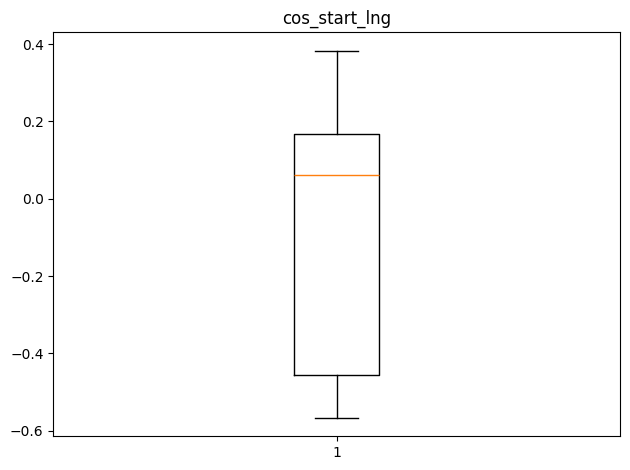

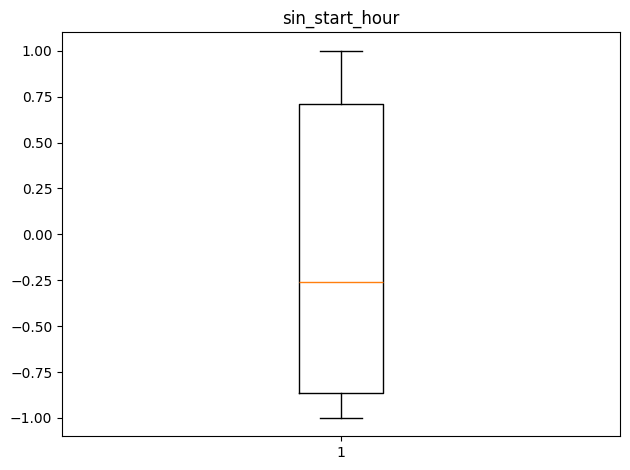

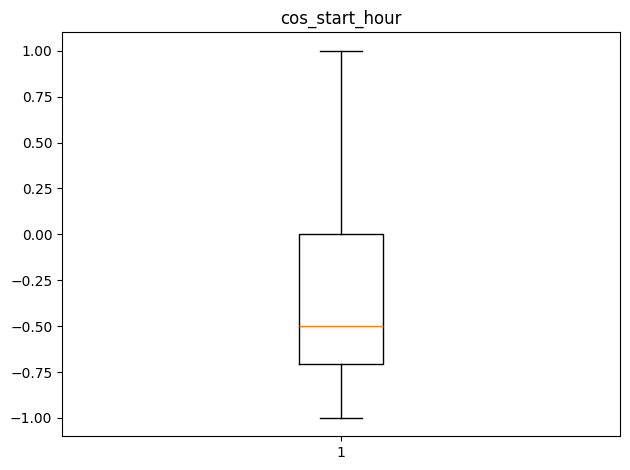

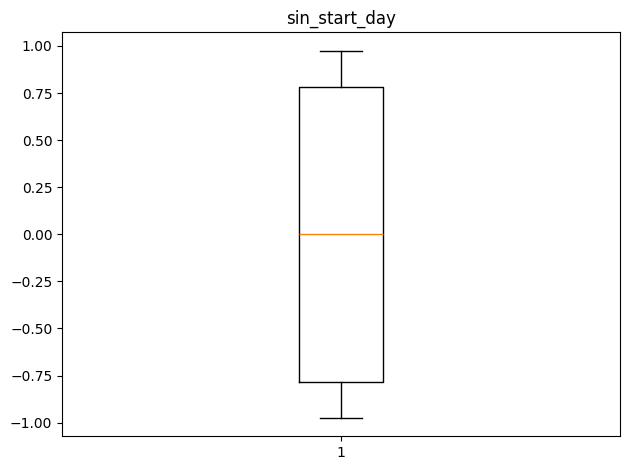

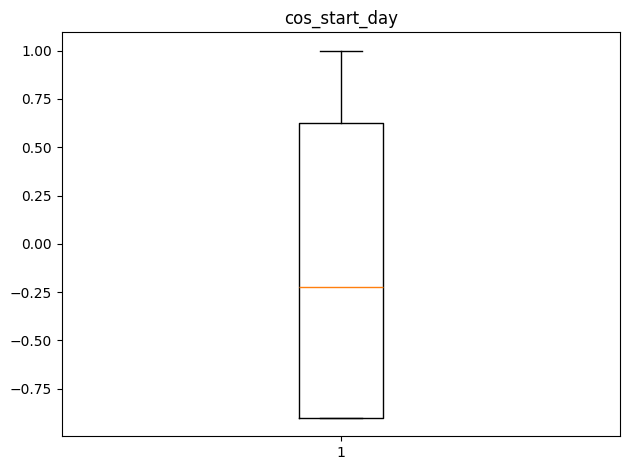

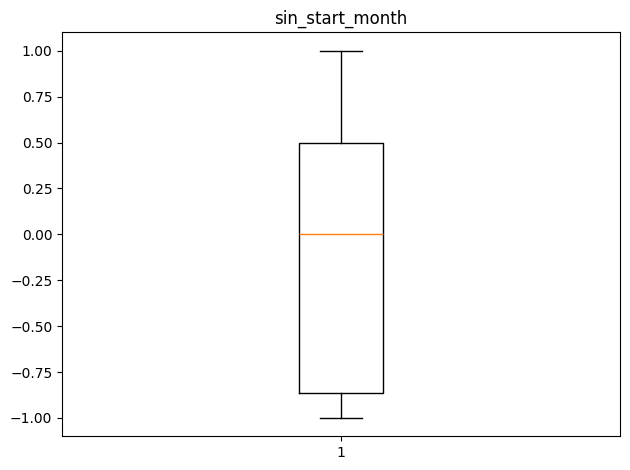

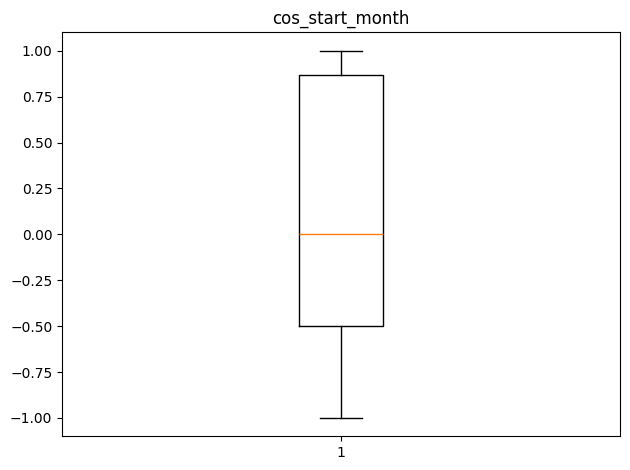

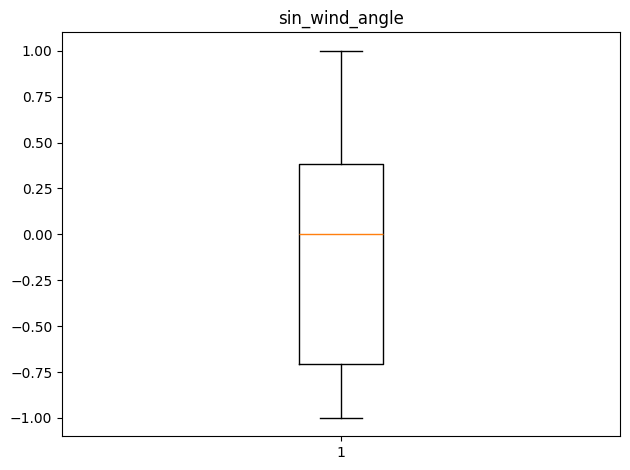

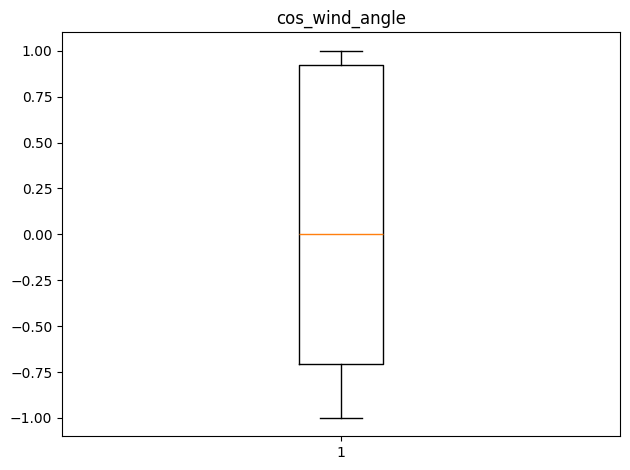

In [9]:
for col in numerical_cols_name:
    plot_box(df=df, feature_name=col, path=FIGURES_DIR / "boxplots" / f"clean_{col}.png")

In [25]:
len(df)

3976010

## Results

In [22]:
x_values = [0.1, 0.3, 0.5, 0.8, 1]

r2_train = {
    "Linear": [0.27, 0.27, 0.27, 0.27, 0.27],
    "XGBoost": [0.68, 0.62, 0.63, 0.61],
    "LightGBM": [0.54, 0.53, 0.53, 0.53],
    "CatBoost": [0.6, 0.57, 0.56],
    "RandomForest": [0.93, 0.94]
}

r2_test = {
    "Linear": [0.27, 0.28, 0.27, 0.27, 0.27],
    "XGBoost": [0.53, 0.55, 0.55, 0.56],
    "LightGBM": [0.51, 0.52, 0.52, 0.52],
    "CatBoost": [0.53, 0.54, 0.54],
    "RandomForest": [0.53, 0.55]
}

rmse_train = {
    "Linear": [32.18, 32.17, 32.13, 32.14, 32.15],
    "XGBoost": [21.16, 23.17, 22.93, 23.44],
    "LightGBM": [25.52, 25.7, 25.9, 25.9],
    "CatBoost": [23.6, 24.7, 24.9],
    "RandomForest": [9.66, 9.4]
}

rmse_test = {
    "Linear": [32.14, 32.1, 32.14, 32.11, 32.15],
    "XGBoost": [25.71, 25.34, 25.1, 24.92],
    "LightGBM": [26.3, 26, 26, 25.9],
    "CatBoost": [25.8, 25.5, 25.4],
    "RandomForest": [25.8, 25.11]
}

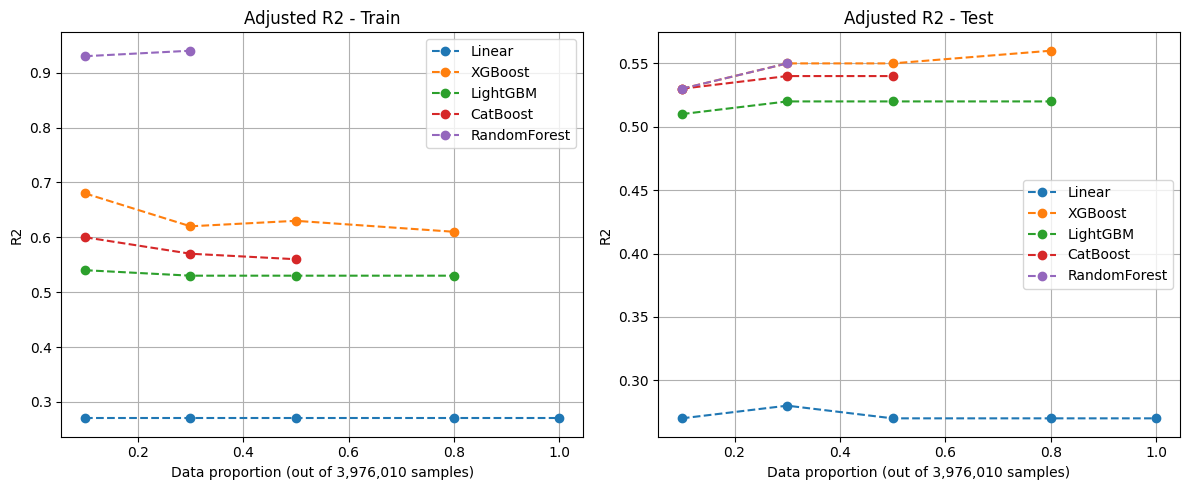

In [29]:
def plot_r2():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, data, title in zip(axes, [r2_train, r2_test], ["Adjusted R2 - Train", "Adjusted R2 - Test"]):
        for model, values in data.items():
            x_vals = x_values[:len(values)]
            ax.plot(x_vals, values, marker='o', linestyle='--', label=model)
        ax.set_title(title)
        ax.set_xlabel("Data proportion (out of 3,976,010 samples)")
        ax.set_ylabel("R2")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "r2_results.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

plot_r2()

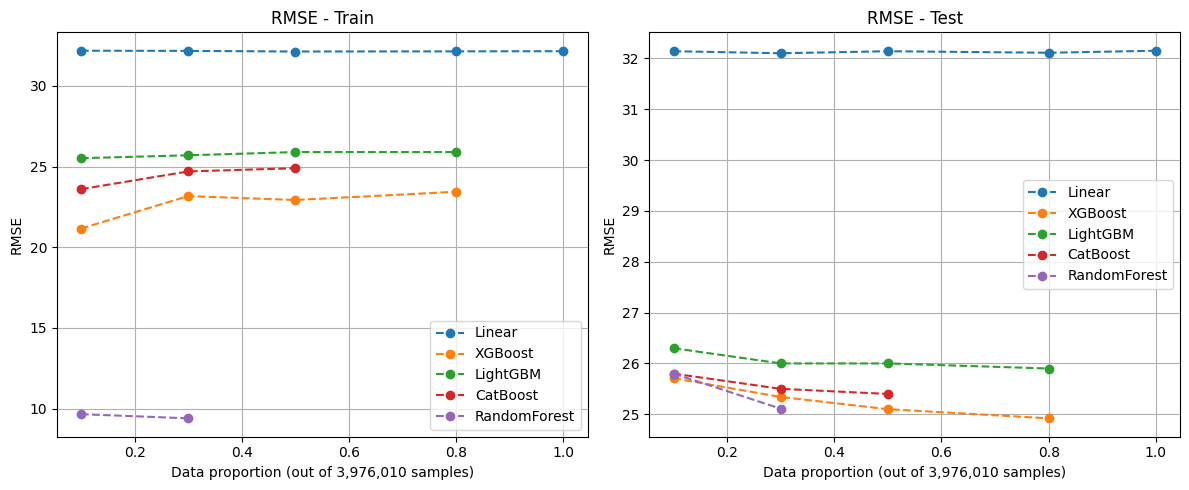

In [30]:
def plot_rmse():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax, data, title in zip(axes, [rmse_train, rmse_test], ["RMSE - Train", "RMSE - Test"]):
        for model, values in data.items():
            x_vals = x_values[:len(values)]
            ax.plot(x_vals, values, marker='o', linestyle='--', label=model)
        ax.set_title(title)
        ax.set_xlabel("Data proportion (out of 3,976,010 samples)")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "rmse_results.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

plot_rmse()